<a href="https://colab.research.google.com/github/rajatmodi62/KaggleSIM/blob/master/Pytorch_SIIM_ACR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir ~/'.kaggle'

In [0]:
cp '/content/gdrive/My Drive/kaggletoken/kaggle.json' ~/'.kaggle'/

In [0]:
!kaggle datasets download jesperdramsch/siim-acr-pneumothorax-segmentation-data

 99% 1.51G/1.52G [00:22<00:00, 91.6MB/s]
100% 1.52G/1.52G [00:22<00:00, 72.4MB/s]


In [0]:
!unzip  -q '/content/siim-acr-pneumothorax-segmentation-data.zip' 

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.0MB 4.3MB/s 


In [0]:
! pip install torchviz


     |████████████████████████████████| 51kB 3.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
import seaborn as sns 
import pydicom
from pydicom.data import get_testdata_files
import os
from matplotlib import cm
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
import sys
import numpy as np
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F
from torchviz import make_dot

#check if the gpu exists or not
device=torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")
#create a custom pytorch dataset 
from torch.utils.data import Dataset
   
class siim_dataset(Dataset):

  def mask2rle(self,img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
      for y in range(height):
          currentColor = img[x][y]
          if currentColor != lastColor:
              if currentColor == 255:
                  runStart = currentPixel;
                  runLength = 1;
              else:
                  rle.append(str(runStart));
                  rle.append(str(runLength));
                  runStart = -1;
                  runLength = 0;
                  currentPixel = 0;
          elif runStart > -1:
              runLength += 1
          lastColor = currentColor;
          currentPixel+=1;

    return " ".join(rle)

  def rle2mask(self,rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


  def read_data_list(self,data_path):
    data_list=[]
    path='/content'
    for root, dirs, files in os.walk(os.path.join(path,data_path),topdown=True):
      for file in files:
        if file.endswith(".dcm"):
          data_list.append(os.path.join(root,file))
    return data_list

  
  def read_data(self,slice):
    print(len(slice))
    #read the data from slice, reshape to 128 tensor and return 
    X_train=torch.zeros((len(slice),self.im_chan,self.im_width,self.im_height),dtype=torch.uint8)
    Y_train=torch.zeros((len(slice),self.im_chan,self.im_width,self.im_height),dtype=torch.uint8)
    print("X_train",X_train.size())
    
    for n, _id in tqdm_notebook(enumerate(slice), total=len(slice)):
      dataset = pydicom.read_file(_id)
      X_train[n][0]=torch.from_numpy(dataset.pixel_array)
      try:
          if '-1' in self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
              Y_train[n][0] = torch.zeros(1024,1024)
              #print(n,"gotten mask 1")
          else:
              if type(self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                  Y_train[n][0] = torch.from_numpy(self.rle2mask(self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024))
                  #print(n,"gotten mask 2")
                  #print("type rle mask",(self.rle2mask(self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024)).shape)
                  #print(self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'])
                  #print("recreating mask",self.mask2rle(self.rle2mask(self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024)),1024,1024)
              else:
                  Y_train[n][0] = torch.zeros(1024, 1024)
                  for x in self.mask_df.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                      Y_train[n][0] =  Y_train[n][0] + torch.from_numpy(rle2mask(x, 1024, 1024))
                  
                  #print(n,"gotten mask 3")

      except :
        #print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n][0] = torch.zeros((1024, 1024)) # Assume missing masks are empty masks.
    #X_train=X_train.view(-1,1,128,128)
    #Y_train=Y_train.view(-1,1,128,128)
    return (X_train,Y_train)
  
  
  def __init__(self, mode):
    self.mode=mode
    self.dcm_load_size=1000
    self.im_height = 1024
    self.im_width = 1024
    self.im_chan = 1
    
    print("reading the mask")
    self.mask_df=pd.read_csv('train-rle.csv',index_col='ImageId')
    print("read the mask")
    
    if self.mode is 'train':
        self.train_sim_list=self.read_data_list("dicom-images-train")
        #self.train_sim_list=self.train_sim_list[:10000]
        print("loaded train dcm images",len(self.train_sim_list))
        

    if self.mode is 'test':
        self.test_sim_list=self.read_data_list("dicom-images-test")
        print("loaded test dcm images",len(self.test_sim_list))
        
  
        
  def __getitem__(self, index):
    if index>= self.__len__():
      return -1
    #batches are between 0 and len-1
    if self.mode is "train":
      if index is self.__len__()-1:
        print("batch lies between", self.dcm_load_size*index, len(self.train_sim_list))
        return self.read_data(self.train_sim_list[self.dcm_load_size*index: len(self.train_sim_list)])
      else:
        print("batch lies between", self.dcm_load_size*index, self.dcm_load_size*(index+1))
        return self.read_data(self.train_sim_list[self.dcm_load_size*index:self.dcm_load_size*(index+1)])
      
      
        
    if self.mode is "test":
      if index is self.__len__()-1:
        print("batch lies between", self.dcm_load_size*index, len(self.test_sim_list))
        return self.read_data(self.test_sim_list[self.dcm_load_size*index: len(self.test_sim_list)])
      else:
        print("batch lies between", self.dcm_load_size*index, self.dcm_load_size*(index+1))
        return self.read_data(self.test_sim_list[self.dcm_load_size*index: self.dcm_load_size*(index+1)])

        
  def __len__(self):  
    if self.mode is 'train':
      if (len(self.train_sim_list)%self.dcm_load_size == 0):
        return int(len(self.train_sim_list)/self.dcm_load_size)
      else:
        return int(len(self.train_sim_list)/self.dcm_load_size) +1
    
    if self.mode is 'test':
      if (len(self.test_sim_list)%self.dcm_load_size == 0):
        return int(len(self.test_sim_list)/self.dcm_load_size)
      else:
        return int(len(self.test_sim_list)/self.dcm_load_size) +1
   

In [0]:

#simple vanilla unet 
class Unet(nn.Module):
  def __init__(self,channels,height,width):
    super(Unet, self).__init__()
    self.nc=channels
    self.h=height
    self.w=width
    self.conv11=nn.Conv2d(self.nc,8,kernel_size=3,padding=1)
    self.conv12=nn.Conv2d(8,8,kernel_size=3,padding=1)
    
    self.conv21=nn.Conv2d(8,16,kernel_size=3,padding=1)
    self.conv22=nn.Conv2d(16,16,kernel_size=3,padding=1)
    
    self.conv31=nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.conv32=nn.Conv2d(32,32,kernel_size=3,padding=1)
    
    self.conv41=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv42=nn.Conv2d(64,64,kernel_size=3,padding=1)
    
    
    self.conv51=nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.conv52=nn.Conv2d(64,64,kernel_size=3,padding=1)
    
    self.conv61=nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.conv62=nn.Conv2d(128,128,kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(kernel_size=2)
    
    #upsampling network , increate the number of layers, concat, and get the outputs
    self.upconv1=nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    
    self.conv71=nn.Conv2d(128,64,kernel_size=3,padding=1)
    self.conv72=nn.Conv2d(64,64,kernel_size=3,padding=1)
    
    self.upconv2=nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
    
    self.conv81=nn.Conv2d(96,64,kernel_size=3,padding=1)
    self.conv82=nn.Conv2d(64,64,kernel_size=3,padding=1)
    
    self.conv91=nn.Conv2d(64,32,kernel_size=3,padding=1)
    self.conv92=nn.Conv2d(32,32,kernel_size=3,padding=1)
    
    self.upconv3=nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
    self.conv10_1=nn.Conv2d(32,16,kernel_size=3,padding=1)
    self.conv10_2=nn.Conv2d(16,16,kernel_size=3,padding=1)
    
    self.upconv4=nn.ConvTranspose2d(16,8,kernel_size=2,stride=2)
    self.conv11_1=nn.Conv2d(16,8,kernel_size=3,padding=1)
    self.conv11_2=nn.Conv2d(8,8,kernel_size=3,padding=1)
    
    self.finalconv=nn.Conv2d(8,1,kernel_size=1)

        
  def forward(self,input):
    c1=F.relu(self.conv11(input))
    c1=F.relu(self.conv12(c1))
    p1=self.pool(c1)
    #8X64X64 
    
    c2=F.relu(self.conv21(p1))
    c2=F.relu(self.conv22(c2))
    p2=self.pool(c2)
    #16x32x32
    
    c3=F.relu(self.conv31(p2))
    c3=F.relu(self.conv32(c3))
    p3=self.pool(c3)
    #32X16X16
    
    c4=F.relu(self.conv41(p3))
    c4=F.relu(self.conv42(c4))
    p4=self.pool(c4)
   
    #64X8X8
    c5=F.relu(self.conv51(p4))
    c5=F.relu(self.conv52(c5))
    p5=self.pool(c5)
    
    #64X64X4
    c55=F.relu(self.conv61(p5))
    c55=F.relu(self.conv62(c55))
    
    #128X4X4
    #upsampling network 
    u6=self.upconv1(c55)
    #64X8X8
    u6=torch.cat((u6,c5),1)
    #128X8X8
    c6=F.relu(self.conv71(u6))
    c6=F.relu(self.conv72(c6))
    
    #64X8X8
    u7=self.upconv2(c6)
    u7=torch.cat((u7,c4),1)
    #96X16X16
    c7=F.relu(self.conv81(u7))  
    c7=F.relu(self.conv82(c7))
    #reduce to 64 dimensions
    
    u7=self.upconv2(c7)
    u7=torch.cat((u7,c3),1)
    c7=F.relu(self.conv91(u7))
    c7= F.relu(self.conv92((c7)))
    
    u8=self.upconv3(c7)
    u8=torch.cat((u8,c2),1)
    c8= F.relu(self.conv10_1((u8)))
    c8= F.relu(self.conv10_2((c8)))
    
    u9=self.upconv4(c8)
    u9=torch.cat((u9,c1),1)
    c9= F.relu(self.conv11_1((u9)))
    c9= F.relu(self.conv11_2((c9)))
    ##now need to concat c1
    
    c10=F.sigmoid(self.finalconv(c9))
    return c10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]              80
            Conv2d-2          [-1, 8, 128, 128]             584
         MaxPool2d-3            [-1, 8, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
            Conv2d-5           [-1, 16, 64, 64]           2,320
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
            Conv2d-8           [-1, 32, 32, 32]           9,248
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
           Conv2d-11           [-1, 64, 16, 16]          36,928
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
           Conv2d-14             [-1, 6

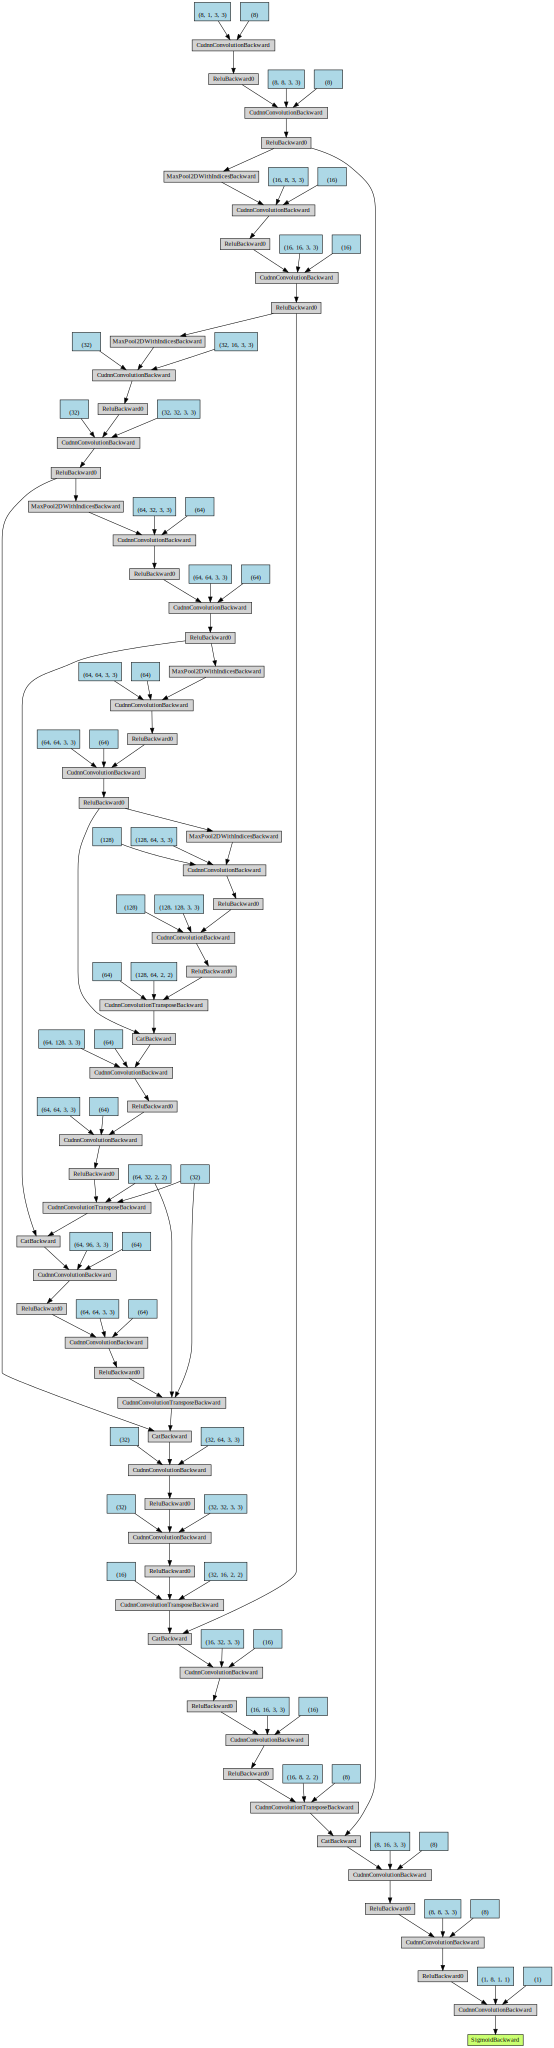

In [0]:

#initialize a unet 
unet= Unet(1,128,128).to(device)
from torchsummary import summary
summary(unet, input_size=(1,128,128))
#check the dynamic graph
a=torch.rand(1,1,128,128,device=device)
output=unet(a.to(device,dtype=torch.float))
make_dot(output)

In [0]:
#define the loss for unet
loss=nn.BCELoss()
optimizer_unet=optim.Adam(unet.parameters())

In [0]:
num_epochs=50
#create the dataset 
train_data=siim_dataset('train')
#number of epochs
for epoch in range(num_epochs):
  print("in epoch ",epoch+1)
  
  for data_index in range(len(train_data)):
    
    X_train_dataloader, Y_train_dataloader=train_data[data_index]
    X_train_dataloader.size()
    dataset=torch.utils.data.TensorDataset(X_train_dataloader, Y_train_dataloader)
    dataloader=torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

    print("loaded dataset number", data_index+1)
    #iterate through the dataset
    
    running_loss=0
    for i,(X_train,Y_train) in enumerate(dataloader):
        X_train=(X_train/127.5)-1
        X_train=X_train.to(device,dtype=torch.float)
        Y_train=Y_train.to(device,dtype=torch.float)
        unet.zero_grad()
        output=unet(X_train)
        error=loss(output,Y_train)
        error.backward()
        optimizer_unet.step()
        running_loss+=error.item()
          
        if i%500==0:
          print('epoch:[%d], data_index:[%d], iteration:[%d], loss: %f' %
                  (epoch + 1, data_index + 1, i, running_loss / 500))     
          running_loss=0
          ;
    print("modi",epoch)
    print('saving model, epoch:[%d], data_index:[%d]',epoch+1,data_index+1)
    #saving the model 
#     torch.save({
#                 'epoch': epoch,
#                 'data_index': data_index,
#                 'model_state_dict': unet.state_dict(),
#                 'optimizer_state_dict': optimizer_unet.state_dict(),
#                 'loss': running_loss,

#                 }, '/content/gdrive/My Drive/Kaggle Competitions/SIM-ACR Pneumothorax Segmentation/unet.pth')



In [0]:
#fetching the sample submission file
!kaggle competitions download -c siim-acr-pneumothorax-segmentation

In [0]:
cp '/content/gdrive/My Drive/Kaggle Competitions/SIM-ACR Pneumothorax Segmentation/unet.pth' .

In [0]:
#load the weights, put the model into training mode
unet= Unet(1,128,128).to(device)
optimizer_unet=optim.Adam(unet.parameters())
checkpoint=torch.load('/content/unet.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
optimizer_unet.load_state_dict(checkpoint['optimizer_state_dict'])
unet.eval()

In [0]:
#read the dataframe 
#submission script
df = pd.read_csv('/content/sample_submission.csv')
tmp = df.groupby('ImageId')['ImageId'].count().reset_index(name='N')
tmp = tmp.loc[tmp.N > 1] #find image id's with more than 1 row -> has pneumothorax mask!
df.loc[df.ImageId.isin(tmp.ImageId),'EncodedPixels'] = f"1 {1024*1024}"

df.to_csv('sample_submission2.csv',index=None)

#list of images whose mask to be predicted
test_dcm_list= list(df.loc[(df.EncodedPixels=='1 1048576')].ImageId)

def write_mask_to_csv(test_image_id,value):
  image_instances=list(df.loc[(df.ImageId==test_dcm_list[test_image_id])].index)
  #print(image_instances)
  for i in image_instances:
    df.iloc[i][1]=value

In [0]:
test_dcm_path=[ test_dcm_list[i]+ '.dcm' for i in range(len(test_dcm_list))]
path='/content/dicom-images-test'
for i in range(len(test_dcm_path)):
  name=test_dcm_path[i]
  for root, dirs, files in os.walk(path):
    if name in files:
      test_dcm_path[i]=os.path.join(root, name)

In [0]:
test_data=siim_dataset("test")
X_test,_=test_data.read_data(test_dcm_path)

reading the mask
read the mask
loaded test dcm images 1377
190
X_train torch.Size([190, 1, 1024, 1024])


In [0]:
for i in range(10):
  X_test=X_test.view(-1,1,1024,1024)
  input=X_test[5].view(-1,1,128,128)
  output=unet(input.to(device,dtype=torch.float))
  output=output.view(-1,1,1024,1024)
  output=output>=0.5
  test_data.mask2rle(output.cpu().numpy(),1024,1024)
  

In [0]:
!kaggle competitions submit -f sample_submission2.csv -m "test submission" -q siim-acr-pneumothorax-segmentation 

In [0]:
train_data=siim_dataset('train')
X_train,Y_train=train_data[0]

reading the mask
read the mask
loaded train dcm images 10712
batch lies between 0 1000
1000
X_train torch.Size([1000, 1, 1024, 1024])


0 gotten mask 2
1 gotten mask 1
2 gotten mask 1
3 gotten mask 2
4 gotten mask 1
5 gotten mask 2
7 gotten mask 2
8 gotten mask 1
9 gotten mask 1
10 gotten mask 1
11 gotten mask 1
12 gotten mask 1
14 gotten mask 1
15 gotten mask 2
16 gotten mask 1
17 gotten mask 1
18 gotten mask 1
19 gotten mask 1
20 gotten mask 1
21 gotten mask 1
22 gotten mask 1
23 gotten mask 1
24 gotten mask 1
25 gotten mask 1
26 gotten mask 1
27 gotten mask 1
28 gotten mask 2
29 gotten mask 1
30 gotten mask 1
31 gotten mask 1
32 gotten mask 2
34 gotten mask 1
35 gotten mask 1
36 gotten mask 1
38 gotten mask 2
39 gotten mask 1
41 gotten mask 1
42 gotten mask 2
43 gotten mask 1
44 gotten mask 1
45 gotten mask 1
47 gotten mask 1
48 gotten mask 1
49 gotten mask 1
50 gotten mask 1
51 gotten mask 1
52 gotten mask 1
53 gotten mask 1
54 gotten mask 1
55 gotten mask 1
56 gotten mask 1
57 gotten mask 1
58 gotten mask 1
59 gotten mask 1
60 gotten mask 1
61 gotten mask 1
63 gotten mask 1
64 gotten mask 1
65 gotten mask 1
66 got

In [0]:
X_train=X_train.view(-1,1,1024,1024)
Y_train=Y_train.view(-1,1,1024,1024)

In [0]:
#dimensions X_train->[1,1024,1024]
def plot_data(iteration,epoch,X_train,Y_train,Y_pred):

  num_img=3
  figure, axis = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
  axis[0].set_title('Train Example')
  axis[1].set_title('Ground Truth')
  axis[2].set_title('Predicted Sample')
  axis[0].imshow(X_train.cpu().numpy(),cmap=plt.cm.bone)
  axis[1].imshow(Y_train.cpu().numpy())
  axis[2].imshow(Y_pred.cpu().numpy())
  title="Epoch :" +str(epoch)+ "Iteration :"+ str(iteration)
  figure.suptitle(title, fontsize=16)

In [0]:
for i in range(10):
  plot_data(X_train[i],Y_train[i],Y_train[i])

NameError: ignored

In [0]:
torch.set_printoptions(edgeitems=100)

In [0]:
X_train_dataloader.size()

torch.Size([1000, 1, 1024, 1024])

In [0]:
delY_train

NameError: ignored

In [0]:
torch.cuda.empty_cache()

In [0]:
torch.cuda.memory_allocated()

2617856

In [0]:
del unet

In [0]:
unet= Unet(1,128,128).to(device)
train_data=siim_dataset('train')
loss=nn.BCELoss()
optimizer_unet=optim.Adam(unet.parameters())

#train on only 1000 images
data_index=0
X_train_dataloader, Y_train_dataloader=train_data[data_index]
X_train_dataloader.size()
dataset=torch.utils.data.TensorDataset(X_train_dataloader, Y_train_dataloader)
dataloader=torch.utils.data.DataLoader(dataset=dataset, batch_size=8, shuffle=False)
print("loaded dataset number", data_index+1)




reading the mask
read the mask
loaded train dcm images 10712
batch lies between 0 1000
1000
X_train torch.Size([1000, 1, 1024, 1024])



loaded dataset number 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0
epoch:[1], iteration:[0], loss: 0.008472


KeyboardInterrupt: ignored

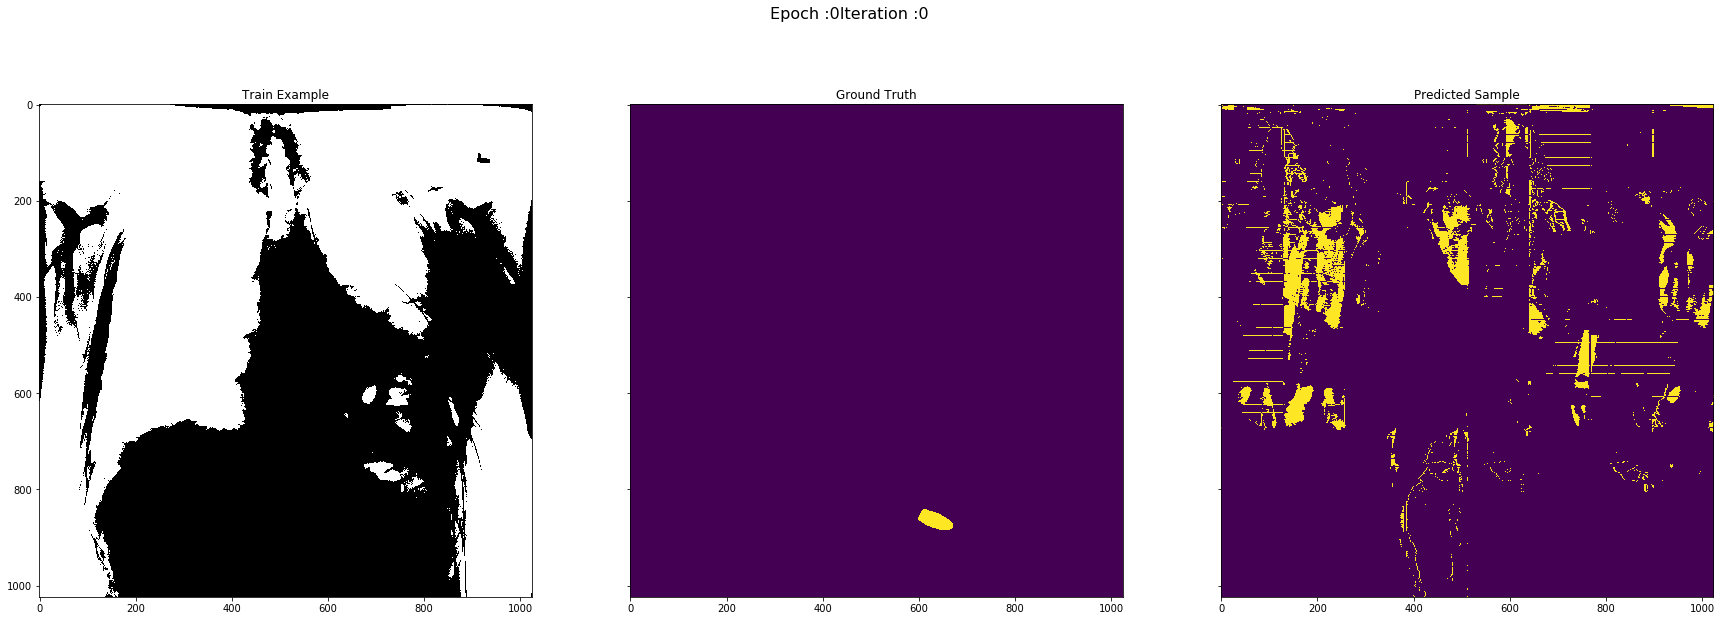

In [0]:
for epoch in range(10):    
    #iterate through the dataset
    
    running_loss=0
    for i,(X_train,Y_train) in enumerate(dataloader):
         
        #print("modi",X_train.size())
        #normalize and resize for input 
        X_train=(X_train/127.5)-1
        X_train=X_train.view(-1,1,128,128)
        Y_train=Y_train.view(-1,1,128,128)
        #print("rajat",X_train.size())
        X_train=X_train.to(device,dtype=torch.float)
        Y_train=Y_train.to(device,dtype=torch.float)
        unet.zero_grad()
        output=unet(X_train)
        X_train=X_train.view(-1,1,1024,1024)[0]
        Y_train=Y_train.view(-1,1,1024,1024)[0]
        Y_train=Y_train/255.
        output=output.view(-1,1,1024,1024)[0]
        error=loss(output,Y_train)
        error.backward()
        optimizer_unet.step()
        output=output>=0.5
        if i%50 is 0:
          print(i)
          with torch.no_grad():
            plot_data(i,epoch,X_train[0],Y_train[0],output[0])
        #print('output shape',output.size())
        running_loss+=error.item()
          
        if i%50==0:
          print('epoch:[%d], iteration:[%d], loss: %f' %
                  (epoch + 1,  i, running_loss / 50))
          running_loss=0
        #print("optimizer shape")

In [0]:
for epoch in range(10):    
    #iterate through the dataset
    
    running_loss=0
    for i,(X_train,Y_train) in enumerate(dataloader):
         
        #print("modi",X_train.size())
        #normalize and resize for input 
        X_train=(X_train/127.5)-1
        X_train=X_train.view(-1,1,128,128)
        Y_train=Y_train.view(-1,1,128,128)
        #print("rajat",X_train.size())
        X_train=X_train.to(device,dtype=torch.float)
        Y_train=Y_train.to(device,dtype=torch.float)
        unet.zero_grad()
        output=unet(X_train)
        X_train=X_train.view(-1,1,1024,1024)[0]
        Y_train=Y_train.view(-1,1,1024,1024)[0]
        output=output.view(-1,1,1024,1024)[0]
        error=loss(output,Y_train)
        error.backward()
        optimizer_unet.step()
        output=output>=0.5
        if i%50 is 0:
          print(i)
          with torch.no_grad():
            plot_data(i,epoch,X_train[0],Y_train[0],output[0])
        #print('output shape',output.size())
        running_loss+=error.item()
          
        if i%50==0:
          print('epoch:[%d], iteration:[%d], loss: %f' %
                  (epoch + 1,  i, running_loss / 50))
          running_loss=0
        #print("optimizer shape")del X_train,Y_train,unet,optimizer_unet,dataset,dataloader

In [0]:
np.mean(Y_train[0].cpu().numpy())

IndexError: ignored

X_train 255


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0
1.0
epoch:[1], iteration:[0], loss: 0.000482
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255
X_train 255


KeyboardInterrupt: ignored

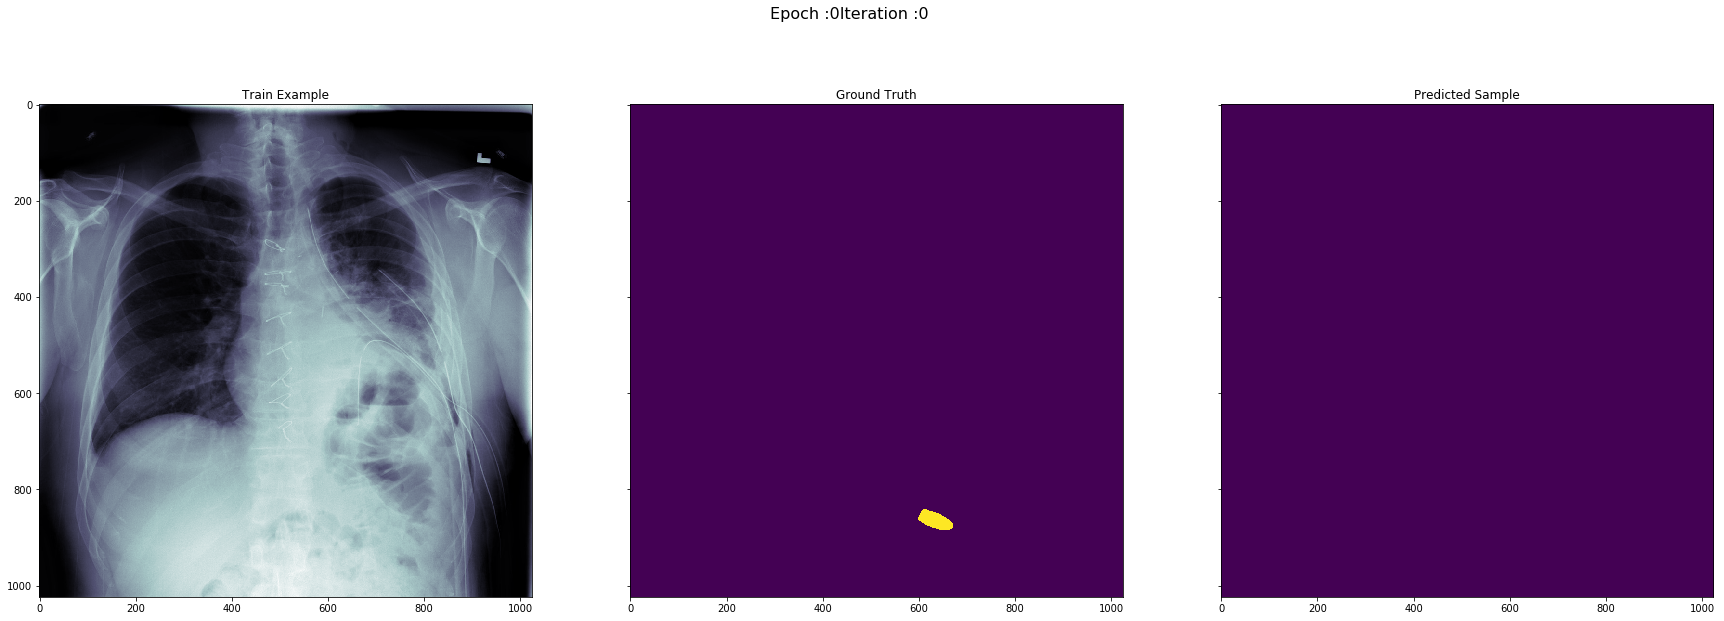

In [0]:
for epoch in range(10):    
    #iterate through the dataset
    
    running_loss=0
    for i,(X_train,Y_train) in enumerate(dataloader):
         
        #print("modi",X_train.size())
        #normalize and resize for input 
        #X_train=(X_train/127.5)-1
        #print("X_train", np.max(X_train.cpu().numpy()))
        X_train=X_train.view(-1,1,128,128)
        Y_train=Y_train.view(-1,1,128,128)
        #print("rajat",X_train.size())
        X_train=X_train.to(device,dtype=torch.float)
        Y_train=Y_train.to(device,dtype=torch.float)
        unet.zero_grad()
        output=unet(X_train)
        X_train=X_train.view(-1,1,1024,1024)[0]
        Y_train=Y_train.view(-1,1,1024,1024)[0]
        Y_train=Y_train/255.
        output=output.view(-1,1,1024,1024)[0]
        error=loss(output,Y_train)
        error.backward()
        optimizer_unet.step()
        output=output>=0.5
        if i%50 is 0:
          print(i)
          with torch.no_grad():
            plot_data(i,epoch,X_train[0],Y_train[0],output[0])
            print(np.max(Y_train.cpu().numpy()))
        #print('output shape',output.size())
        running_loss+=error.item()
          
        if i%50==0:
          print('epoch:[%d], iteration:[%d], loss: %f' %
                  (epoch + 1,  i, running_loss / 50))
          running_loss=0
        #print("optimizer shape")